# Model Reduction and Linear System Identification

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cihan-ates/data-driven-engineering/blob/master/DDE_I_ML_Dynamical_Systems/Lecture%2012/Lecture_10.ipynb)


# Important Note

Lecture notes and notebooks must not be copied and/or distributed without the express permission of ITS.






# 2. Preparing the environment

Import the Python libraries that we will need to (i) load the data, (ii) analyze it, (iii) create our model, (iv) process the results.

In [1]:
!pip install scikit-learn==0.23

In [2]:
# Installing the PySINDy:
!pip install pysindy

In [3]:
# Loading libraries:
#
#Fundamentals
import numpy as np
import pandas as pd
import os
# Aux. libs:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint
from sklearn.linear_model import Lasso
from matplotlib.cm import rainbow
from scipy.io import loadmat
import itertools


#Other models
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import ElasticNet

# Data Preparation and Scoring
from sklearn import preprocessing as pp
from scipy import stats
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from matplotlib.colors import LogNorm
import matplotlib as mpl

In [6]:
#
#ML libraries
import pysindy as ps
from pysindy.feature_library import CustomLibrary

# SINDy: Sparse Identification of Nonlinear Dynamics

PySINDy is a Python package that implements the SINDy-family algorithms. 
SINDy is a class of data-driven algorithms for system identification mainly developed by Steve Brunton and Nathan Kutz at the University of Washington. We will use SINDy as a case study to show you the strength of model reduction, linear system identification and the usefulness of sparse representation. 

The original work can be accessed from here:

https://www.pnas.org/content/113/15/3932

It is also described briefly in the recommended text book DDE. There are even videos described by Prof. Brunton himself:

https://www.youtube.com/watch?v=gSCa78TIldg

Its integration with AE:

https://www.youtube.com/watch?v=WHhDgxkiR9c

The core idea behind SINDy is sparse regression over a time series data to generate governing equations. 

We will not implement the model, as it is already available on GitHub. We will treat it as an extension of sci-kit, which you are already familiar with.

For its API documentation, please refer to:

https://pysindy.readthedocs.io/en/latest/api/pysindy.html


# Exploring PySINDy

In order to have a better understanding, let's start with a simple text book example (literally text book: see DDE sources). 

Here we have a system of ODEs, particularly two dependent variables. You may use your imagination as you wish: for example, a reaction happening in a well-mixed reactor or a particle happly decaying on a streamline. 

We will follow the same steps:

+ data prepocessing

+ setting hyperparameters

+ model training

+ testing model predictions.


Here testing refers to the reconstruction of the model equations and time-marching / forecasting given an initial condition.



## Data Preprocessing

We will create a 1D numpy array for explicit time steps, then assume the relationship x(t) and y(t); our independent variables.

Then, we will create our input matrix X by combining x and y into X.

In [7]:
# This is a very simple example. We will build the data from a known equation
# then learn the model from the data. 
#
# independent variable:
t = np.linspace(0, 1, 100)
# dependent variable 1:
x = 0.618 * np.exp(-1.618 * t)
#dependent variable 2:
y = 0.618 * np.exp(t)
#Adding data column by column:
X = np.stack((x, y), axis=-1)

In [8]:
#Have a glimpse of X
print(x.shape, y.shape, X.shape)

(100,) (100,) (100, 2)


## Model Hyperparameters

We have III basic "hyperparameters" for SINDy:

1. hypothesis / feature library $\Theta$

2. solution method / optimizer

3. if needed, differentiation method.

After defining the hyperparameters, we will build our model object as usual (ie. scikit-learn).

In [9]:
# This is the second step. Since we do not know the derivative of x and y,
# we need to calculate them numerically. We will use SINDy for that:
#
#------------------------------------
# Hyperparameters:
#------------------------------------
# select a differentiation method from the differentiation submodule:
#https://pysindy.readthedocs.io/en/latest/api/pysindy.differentiation.html
differentiation_method = ps.differentiation.finite_difference.FiniteDifference(order=2)

#candidate library from the feature_library submodule:
#https://pysindy.readthedocs.io/en/latest/api/pysindy.feature_library.html
feature_library = ps.feature_library.PolynomialLibrary(degree=3)

# optimizer selection:
#https://pysindy.readthedocs.io/en/latest/api/pysindy.optimizers.html
#here we picked "Sequentially thresholded least squares algorithm"
optimizer = ps.optimizers.STLSQ(threshold=0.2)

#Building the model:
model = ps.SINDy(
    differentiation_method=differentiation_method,
    feature_library=feature_library,
    optimizer=optimizer,
    feature_names=["x", "y"]
)

## Model Training

Training step is also simple. We will pass X with the time resolution information. It can take different forms: here we have list of time.

In [10]:
# Training the model:
# Similar to scikit-learn objects, we will fit our data X on our model.
# we do not pass labels here as the model will calculate the diffentials. 
# instead, we pass the time data.
#
# To see how fit method works, you may refer here:
#https://pysindy.readthedocs.io/en/latest/api/pysindy.html#submodules
# fit(x, t=None, x_dot=None, u=None, multiple_trajectories=False, unbias=True, quiet=False)
#.................................................................................
#– If t is a float, it specifies the timestep between each sample. 
# If array-like, it specifies the time at which each sample was collected. 
# In this case the values in t must be strictly increasing. 
# In the case of multi-trajectory training data, t may also be a list of arrays 
# containing the collection times for each individual trajectory. 
# If None, the default time step t_default will be used.
#.................................................................................
model.fit(X, t=t);

When the model is fitted, SINDy will find a combination of the hypothesis library, giving a sparse representation of the system dynamics. We can see the outcome with `.print()`.

Our true functions are:

```
# dependent variable 1:
x = 0.618 * np.exp(-1.618 * t)
#dependent variable 2:
y = 0.618 * np.exp(t)
```
Note that we are using polynomial representations in $\Theta$.


In [11]:
#Let's see our fitting:
model.print()

x' = -1.617 x + 0.001 x^2 + -0.004 x^2 y
y' = 1.000 y


## Modeling the Dynamics of the Dataset

After the training, we can use our model to make predictions about the future, given initial state.

In [12]:
# Creating the test data:
#-------------------------
# Initial state of the system:
x0 = 1.618
y0 = 0.618
# independent variable:
t_test = np.linspace(0, 1, 100)
# dependent variables with new initial conditions:
x_test = x0 * np.exp(-1.618 * t_test)
y_test = y0 * np.exp(t_test)

#Simulating:
#-------------------------
sim = model.simulate([x0, y0], t=t_test)

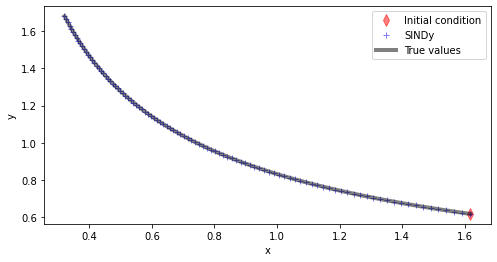

In [13]:
#Plotting the results:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(x0, y0, "rd", label="Initial condition", alpha=0.5, markersize=8)
ax.plot(sim[:, 0], sim[:, 1], "b+", label="SINDy",alpha=0.5, linewidth=4)
ax.plot(x_test, y_test, "k", label="True values", alpha=0.5, linewidth=4)
ax.set(xlabel="x", ylabel="y")
ax.legend()
fig.show()

It works just fine!

## Why the hypothesis library is important?

In the above example, polynomial library was chosen to create a sparse representation of the true dynamical system. What will happen if you change the "hypothesis"?

Let's see with an example:

In [14]:
# Updating the library with trigonometric functions:
feature_library = ps.FourierLibrary()

model = ps.SINDy(
    differentiation_method=differentiation_method,
    feature_library=feature_library,
    optimizer=optimizer,
    feature_names=["x", "y"]
)
model.fit(X, t=t)
model.print()

x' = -1.673 sin(1 x)
y' = 0.550 sin(1 x) + 1.046 cos(1 x) + 0.460 sin(1 y) + -1.014 cos(1 y)


In [15]:
# Creating the test data:
#-------------------------
# Initial state of the system:
x0 = 1.618
y0 = 0.618
# independent variable:
t_test = np.linspace(0, 1, 100)
# dependent variables with new initial conditions:
x_test = x0 * np.exp(-1.618 * t_test)
y_test = y0 * np.exp(t_test)

#Simulating:
#-------------------------
sim = model.simulate([x0, y0], t=t_test)

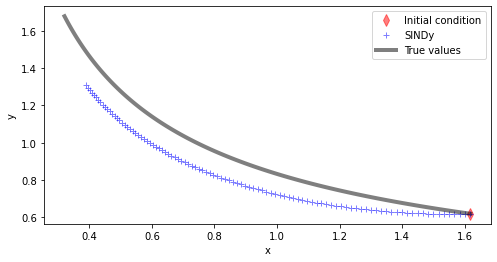

In [16]:
#Plotting the results:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(x0, y0, "rd", label="Initial condition", alpha=0.5, markersize=8)
ax.plot(sim[:, 0], sim[:, 1], "b+", label="SINDy",alpha=0.5, linewidth=4)
ax.plot(x_test, y_test, "k", label="True values", alpha=0.5, linewidth=4)
ax.set(xlabel="x", ylabel="y")
ax.legend()
fig.show()

# Other Simple Examples from SINDy

Here I am adding the [official examples given in the paper](https://www.pnas.org/content/113/15/3932) to further illustrate the capabilities of the approach. 

### Linear 2D ODE:
$\
\begin{bmatrix}
x\\y
\end{bmatrix}
=
\begin{bmatrix}
-0.1&2\\2 & -0.1
\end{bmatrix}
\begin{bmatrix}
x\\y
\end{bmatrix}
$

In [17]:
# Data generation:
def f(x, t):
    return [
        -0.1 * x[0] + 2 * x[1],
        -2 * x[0] - 0.1 * x[1]
    ]
# Training set:
dt = 0.01
t_train = np.arange(0, 25, dt)
x0_train = [2, 0]
x_train = odeint(f, x0_train, t_train)

In [18]:
# Model training:
poly_order = 5
threshold = 0.05

model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold),
    feature_library=ps.PolynomialLibrary(degree=poly_order),
)
model.fit(x_train, t=dt)
model.print()

x0' = -0.100 x0 + 2.000 x1
x1' = -2.000 x0 + -0.100 x1


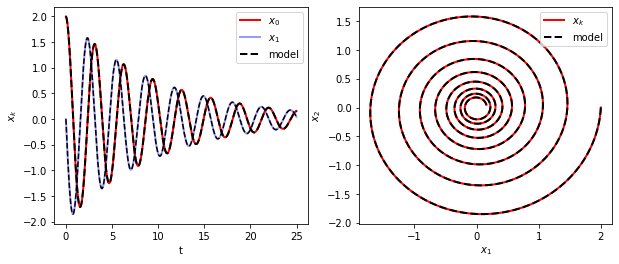

In [19]:
# Simulate and plot the results

x_sim = model.simulate(x0_train, t_train)
plot_kws = dict(linewidth=2)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(t_train, x_train[:, 0], "r", label="$x_0$", **plot_kws)
axs[0].plot(t_train, x_train[:, 1], "b", label="$x_1$", alpha=0.4, **plot_kws)
axs[0].plot(t_train, x_sim[:, 0], "k--", label="model", **plot_kws)
axs[0].plot(t_train, x_sim[:, 1], "k--")
axs[0].legend()
axs[0].set(xlabel="t", ylabel="$x_k$")

axs[1].plot(x_train[:, 0], x_train[:, 1], "r", label="$x_k$", **plot_kws)
axs[1].plot(x_sim[:, 0], x_sim[:, 1], "k--", label="model", **plot_kws)
axs[1].legend()
axs[1].set(xlabel="$x_1$", ylabel="$x_2$")
fig.show()

### Cubic ODE:

### Linear 2D ODE:
$\
\begin{bmatrix}
x\\y
\end{bmatrix}
=
\begin{bmatrix}
-0.1&2\\2 & -0.1
\end{bmatrix}
\begin{bmatrix}
x^3\\y^3
\end{bmatrix}
$

In [20]:
# Data Generation:
def f(x, t):
    return [
        -0.1 * x[0] ** 3 + 2 * x[1] ** 3,
        -2 * x[0] ** 3 - 0.1 * x[1] ** 3,
    ]
dt = 0.01
t_train = np.arange(0, 25, dt)
x0_train = [2, 0]
x_train = odeint(f, x0_train, t_train)

In [21]:
# Model training:
# Fit the model

poly_order = 5
threshold = 0.05

model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold),
    feature_library=ps.PolynomialLibrary(degree=poly_order),
)
model.fit(x_train, t=dt)
model.print()

x0' = -0.100 x0^3 + 1.999 x1^3
x1' = -1.999 x0^3 + -0.100 x1^3


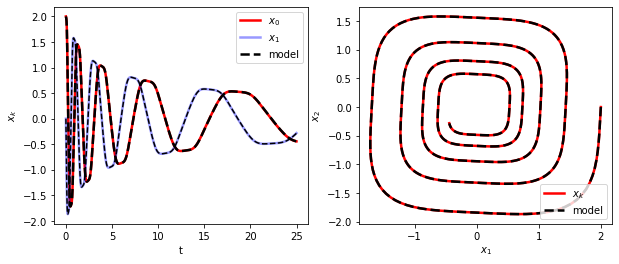

In [22]:
# Simulate and plot the results

x_sim = model.simulate(x0_train, t_train)
plot_kws = dict(linewidth=2.5)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(t_train, x_train[:, 0], "r", label="$x_0$", **plot_kws)
axs[0].plot(t_train, x_train[:, 1], "b", label="$x_1$", alpha=0.4, **plot_kws)
axs[0].plot(t_train, x_sim[:, 0], "k--", label="model", **plot_kws)
axs[0].plot(t_train, x_sim[:, 1], "k--")
axs[0].legend()
axs[0].set(xlabel="t", ylabel="$x_k$")

axs[1].plot(x_train[:, 0], x_train[:, 1], "r", label="$x_k$", **plot_kws)
axs[1].plot(x_sim[:, 0], x_sim[:, 1], "k--", label="model", **plot_kws)
axs[1].legend()
axs[1].set(xlabel="$x_1$", ylabel="$x_2$")
fig.show()

### Linear 3D ODE:
$\
\begin{bmatrix}
x\\y\\z
\end{bmatrix}
=
\begin{bmatrix}
-0.1&  2   &0\\
  2 & -0.1 &0\\
  0 &  0   &-0.3
\end{bmatrix}
\begin{bmatrix}
x\\y\\z
\end{bmatrix}
$

In [23]:
# Generate the data:

def f(x, t):
    return [
        -.1 * x[0] + 2 * x[1],
        -2 * x[0] - .1 * x[1],
        -0.3 * x[2]
    ]
dt = .01
t_train = np.arange(0, 50, dt)
x0_train = [2, 0, 1]
x_train = odeint(f, x0_train, t_train)

In [24]:
# Training the model:
poly_order = 5
threshold = 0.01

model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold),
    feature_library=ps.PolynomialLibrary(degree=poly_order)
)
model.fit(x_train, t=dt)
model.print()

x0' = -0.100 x0 + 2.000 x1
x1' = -2.000 x0 + -0.100 x1
x2' = -0.300 x2


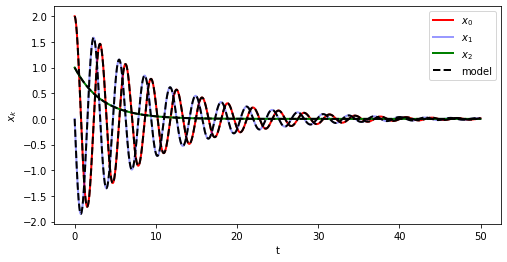

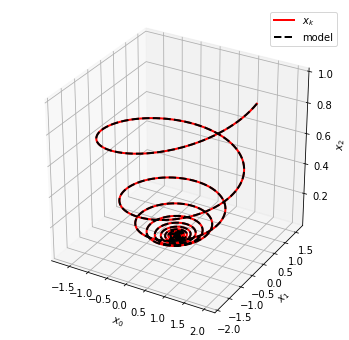

In [25]:
# Simulating the results:

x_sim = model.simulate(x0_train, t_train)
plot_kws = dict(linewidth=2)

fig = plt.figure(figsize=(8, 4))
plt.plot(t_train, x_train[:, 0], "r", label="$x_0$", **plot_kws)
plt.plot(t_train, x_train[:, 1], "b", label="$x_1$", alpha=0.4, **plot_kws)
plt.plot(t_train, x_train[:, 2], "g", label="$x_2$", **plot_kws)
plt.plot(t_train, x_sim[:, 0], "k--", label="model", **plot_kws)
plt.plot(t_train, x_sim[:, 1], "k--", **plot_kws)
plt.plot(t_train, x_sim[:, 2], "k--", **plot_kws)
plt.legend()
plt.xlabel("t")
plt.ylabel("$x_k$")
fig.show()

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection="3d")
ax.plot(x_train[:, 0], x_train[:, 1], x_train[:, 2], "r", label="$x_k$", **plot_kws)
ax.plot(x_sim[:, 0], x_sim[:, 1], x_sim[:, 2], "k--", label="model", **plot_kws)
ax.set(xlabel="$x_0$", ylabel="$x_1$", zlabel="$x_2$")
ax.legend()
fig.show()

### What happens when you have noise in your data?

Let's apply one of these simple examples with noisy data and try to see whether we can still learn the same dynamics or not.

$\
\begin{bmatrix}
x\\y
\end{bmatrix}
=
\begin{bmatrix}
-0.1&2\\2 & -0.1
\end{bmatrix}
\begin{bmatrix}
x\\y
\end{bmatrix}
$

In [26]:
# Data generation:
def f(x, t):
    return [
        -0.1 * x[0] + 2 * x[1],
        -2 * x[0] - 0.1 * x[1]
    ]
# Training set:
dt = 0.01
t_train = np.arange(0, 25, dt)
x0_train = [2, 0]
x_train = odeint(f, x0_train, t_train)

In [27]:
x_train[:3]

array([[ 2.        ,  0.        ],
       [ 1.99760142, -0.03995734],
       [ 1.99440741, -0.07981886]])

In [28]:
#Adding artificial noise to X:
noise_factor = 0.10
x_train_noisy = x_train.copy() + noise_factor*np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_train_noisy[:3]

array([[ 2.100417  , -0.05737666],
       [ 2.1132974 , -0.17153514],
       [ 1.83808821, -0.11267365]])

In [29]:
# Model training:
poly_order = 2
threshold = 0.05

model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold),
    feature_library=ps.PolynomialLibrary(degree=poly_order),
)
model.fit(x_train_noisy, t=dt)
model.print()

x0' = 1.959 x1 + 0.087 x0^2 + -0.064 x1^2
x1' = -1.984 x0 + -0.100 x1


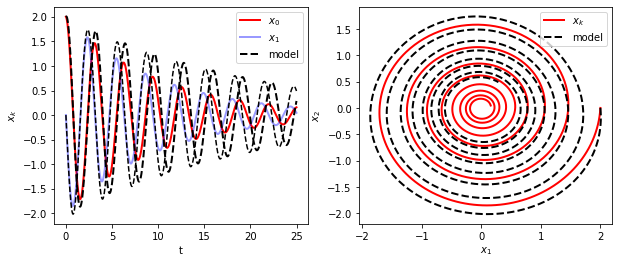

In [30]:
# Simulate and plot the results

x_sim = model.simulate(x0_train, t_train)
plot_kws = dict(linewidth=2)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(t_train, x_train[:, 0], "r", label="$x_0$", **plot_kws)
axs[0].plot(t_train, x_train[:, 1], "b", label="$x_1$", alpha=0.4, **plot_kws)
axs[0].plot(t_train, x_sim[:, 0], "k--", label="model", **plot_kws)
axs[0].plot(t_train, x_sim[:, 1], "k--")
axs[0].legend()
axs[0].set(xlabel="t", ylabel="$x_k$")

axs[1].plot(x_train[:, 0], x_train[:, 1], "r", label="$x_k$", **plot_kws)
axs[1].plot(x_sim[:, 0], x_sim[:, 1], "k--", label="model", **plot_kws)
axs[1].legend()
axs[1].set(xlabel="$x_1$", ylabel="$x_2$")
fig.show()

# Lorenz Attractor

The Lorenz system is an interesting system of ODEs, first studied by E. Lorenz (1963). 

It has become a symbol of chaotic systems in time, which is observed for certain parameters and initial conditions.

We will use the famous set of parameters:

$\rho = 28.0$

$\sigma = 10.0$

$\beta = 8.0 / 3.0$

where

$\ x' = \sigma(y-x)$

$\ y' = \rho x-y-xz$

$\ z' = xy-\beta z$

The reason why this set is so famaous is the fact that it yields a Lorenz system with chaotic solutions.

Further references for those who are interested:

https://www2.physics.ox.ac.uk/sites/default/files/profiles/read/lect6-43147.pdf

https://aip.scitation.org/doi/10.1063/1.5095466

We will see how difficult it is to simulate systems with chaotic nature.

## Data Preprocessing

We will create our function vector z to represent x,y,z of the Lorenz system. This will be achieved by defining a `lorenz` function.

Note that we do have a set of ODEs, not the data at the begining. So, we will use ODEs to generate data in time.

We will also fix the randomness for reproducibility. 

In [31]:
#Seeding the R for reproducibility:
np.random.seed(2021)

In [32]:
# Defining the Lorenz attractor function:
def lorenz(z, t):
    return [
        10 * (z[1] - z[0]),
        z[0] * (28 - z[2]) - z[1],
        z[0] * z[1] - (8 / 3) * z[2]
    ]

Here we will create the training data by integrating the ODEs for a given initial state. Here it is fixed as `[-5, 5, 30]`.

We will use `odeint` for integration from `scipy.integrate`:

In [33]:
#Training data:
#---------------------------------------
# time interval:
dt = .002
# independent variable generation:
t_train = np.arange(0, 10, dt)
#input vector for Lorenz function:
x0_train = [-5, 5, 30]
# Integrating ODE with lsoda:
x_train = odeint(lorenz, x0_train, t_train)

In [34]:
x_train[:3]

array([[-5.        ,  5.        , 30.        ],
       [-4.8018969 ,  5.00857609, 29.79150695],
       [-4.60757391,  5.01444621, 29.58601384]])

## Model hyperparameters

In [35]:
# This is the second step. Since we do not know the derivative of x and y,
# we need to calculate them numerically. We will use SINDy for that:
#
#------------------------------------
# Hyperparameters:
#------------------------------------
# select a differentiation method from the differentiation submodule:
#https://pysindy.readthedocs.io/en/latest/api/pysindy.differentiation.html
differentiation_method = ps.differentiation.finite_difference.FiniteDifference(order=2)

#candidate library from the feature_library submodule:
#https://pysindy.readthedocs.io/en/latest/api/pysindy.feature_library.html
feature_library = ps.feature_library.PolynomialLibrary(degree=3)

# optimizer selection:
#https://pysindy.readthedocs.io/en/latest/api/pysindy.optimizers.html
#here we picked "Sequentially thresholded least squares algorithm"
optimizer = ps.optimizers.STLSQ(threshold=0.2)

## Model Training

We will train the model to extract sparse representation of the Lorenz system. Note that here we pass a single time value as the time step interval.

In [36]:
# Building the model:
model = ps.SINDy(    
    differentiation_method=differentiation_method,
    feature_library=feature_library,
    optimizer=optimizer)
model.fit(x_train, t=dt)
model.print()

x0' = -9.999 x0 + 9.999 x1
x1' = 27.992 x0 + -0.998 x1 + -1.000 x0 x2
x2' = -2.666 x2 + 1.000 x0 x1


Note that the model parameters were 10, 28 and 8/3 in the ODEs. 

## Testing the model outcomes:

We will generate a test data, similar to the training dataset.

In [37]:
# Creating the test data with odeint:
t_test = np.arange(0, 15, dt)
x0_test = np.array([3, 5, 8])
x_test = odeint(lorenz, x0_test, t_test)

### Evaluating the results:

PySINDy also has evaluation score (similar to scikit-learn models). 

It returns a score for the time derivative prediction produced by the model:

`score(x, t=None, x_dot=None, u=None, multiple_trajectories=False, metric=<function r2_score>, **metric_kws)`

+ Note that  if `x_dot` is not provided (None), the time derivatives of the training data will be computed using the specified differentiation method.

+ Default metric is the R^2 coefficient of determination. If you want to use an alternative, it is compatible to scikit-learn, so you can call the metric of your choice. 


In [38]:
# Compare SINDy-predicted derivatives with finite difference derivatives:
# note that .score returns a score for model prediction of x.dot
print('Model score: %f' % model.score(x_test, t=dt))

Model score: 1.000000


## Comparing data driven derivatives with the numerical methods:

In SINDy, we have the method `differentiate` to perform numerical differentiation. It applies `self.differentiation_method ` to the data.

We can use it as an alternative way to judge the performance of our data driven approach.


In [39]:
model.print()

x0' = -9.999 x0 + 9.999 x1
x1' = 27.992 x0 + -0.998 x1 + -1.000 x0 x2
x2' = -2.666 x2 + 1.000 x0 x1


In [40]:
# Predicting derivatives by using the learned sparse model:
x_dot_test_predicted = model.predict(x_test)

In [41]:
x_dot_test_predicted[:3]

array([[19.99832216, 54.98920066, -6.33268008],
       [20.69862147, 55.72916441, -5.76026882],
       [21.39994475, 56.49308594, -5.16999059]])

In [42]:
# Compute derivatives with a finite difference method, for comparison:
x_dot_test_computed = model.differentiate(x_test, t=dt)

In [43]:
x_dot_test_computed[:3]

array([[20.00011584, 54.99996027, -6.33314324],
       [20.70053124, 55.74403153, -5.75788547],
       [21.40199011, 56.50801413, -5.16741527]])

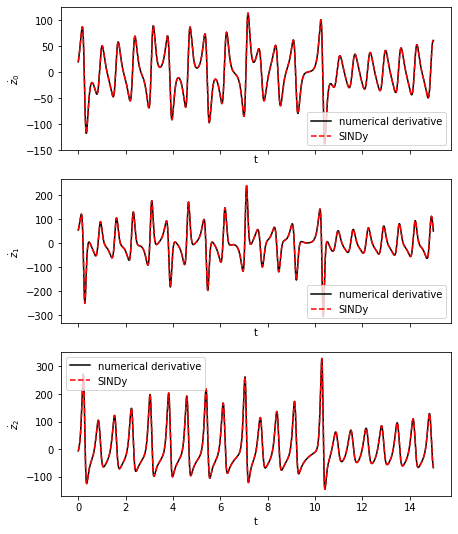

In [ ]:
# Comparing over plots for each element in z ==> '3'
fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(x_test.shape[1]):
    axs[i].plot(t_test, x_dot_test_computed[:, i],
                'k', label='numerical derivative')
    axs[i].plot(t_test, x_dot_test_predicted[:, i],
                'r--', label='SINDy')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$\dot z_{}$'.format(i))
fig.show()

## Simulating further points in time:

A more difficult task would be simulating further points in time, as the model dynamics have chaotic nature. 

Lets see what we can get.

For that purpose, we will use `simulate` method in PySINDy. As the name implies, it simulates the SINDy model forward in time:

https://pysindy.readthedocs.io/en/latest/api/pysindy.html?highlight=.simulate#pysindy.SINDy.simulate

In [44]:
# Initial conditions for z:
x0_test

array([3, 5, 8])

In [45]:
# Simulate the evolution of the initial condition in time with the SINDy model
x_test_sim = model.simulate(x0_test, t_test)
x_test_sim[:3]

array([[3.        , 5.        , 8.        ],
       [3.04069663, 5.11071429, 7.98790404],
       [3.08279445, 5.22293235, 7.97697046]])

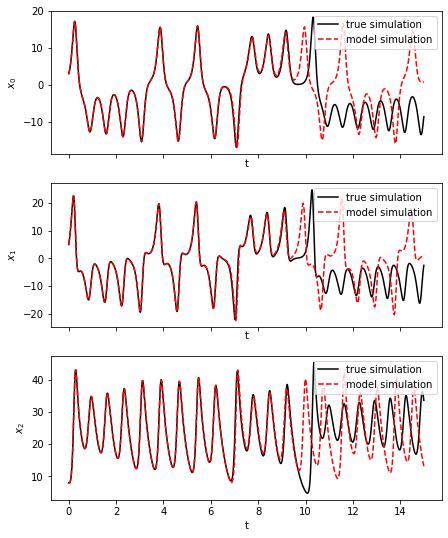

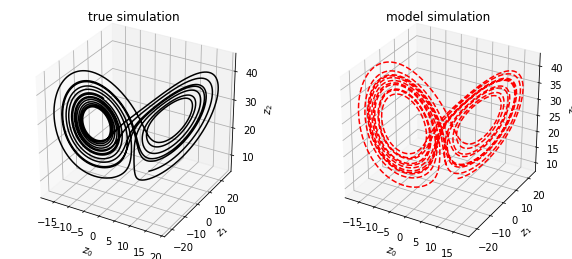

In [46]:
# Comparing the results with the data:

fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(x_test.shape[1]):
    axs[i].plot(t_test, x_test[:, i], 'k', label='true simulation')
    axs[i].plot(t_test, x_test_sim[:, i], 'r--', label='model simulation')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$x_{}$'.format(i))

fig = plt.figure(figsize=(10, 4.5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(x_test[:, 0], x_test[:, 1], x_test[:, 2], 'k')
ax1.set(xlabel='$z_0$', ylabel='$z_1$',
        zlabel='$z_2$', title='true simulation')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(x_test_sim[:, 0], x_test_sim[:, 1], x_test_sim[:, 2], 'r--')
ax2.set(xlabel='$z_0$', ylabel='$z_1$',
        zlabel='$z_2$', title='model simulation')

fig.show()

# Integration with Scikit-learn

We have seen useful tools from scikit-learn in the early weeks. You may wish to combine them with SINDy, which is quite possible.

Below you will find some official examples.

## Lorenz Model Optimization with  Cross-validation (including TimeSeriesSplit)

In [47]:
# Defining base model
model = ps.SINDy(t_default=dt)

In [48]:
# Dictionary for GridSearch
#----------------------------
#here we will create a possibility space for our hyperparameters.
param_grid = {
    "optimizer__threshold": [0.001, 0.01, 0.1],
    "optimizer__alpha": [0.01, 0.05, 0.1],
    "feature_library": [ps.PolynomialLibrary(), ps.FourierLibrary()],
    "differentiation_method__order": [1, 2]
}

In [49]:
# Note that we are dealing with time series. Therefore, we can not create 
# arbitrarily selected data and the samples must follow the arrow of time.
# For that purpose, we will use 'TimeSeriesSplit' of scikit-learn.
search = GridSearchCV(
    model,
    param_grid,
    cv=TimeSeriesSplit(n_splits=5)
)

In [50]:
# Model training...
search.fit(x_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             estimator=SINDy(differentiation_method=FiniteDifference(),
                             feature_library=PolynomialLibrary(),
                             optimizer=STLSQ(), t_default=0.002),
             param_grid={'differentiation_method__order': [1, 2],
                         'feature_library': [PolynomialLibrary(),
                         'optimizer__alpha': [0.01, 0.05, 0.1],
                         'optimizer__threshold': [0.001, 0.01, 0.1]})

In [51]:
# Getting the results:
print("Best parameters:", search.best_params_)
search.best_estimator_.print()

Best parameters: {'differentiation_method__order': 2, 'feature_library': PolynomialLibrary(), 'optimizer__alpha': 0.01, 'optimizer__threshold': 0.01}
x0' = -9.999 x0 + 9.999 x1
x1' = 27.992 x0 + -0.998 x1 + -1.000 x0 x2
x2' = -2.666 x2 + 1.000 x0 x1


## Using an optimizer from scikit-learn

This is another example of scikit-learn integration. Here we will call a sparse optimizer from scikit-learn as a linear optimizer: `ElasticNet` (see Regression week for more details)

In [52]:
model = ps.SINDy(optimizer=ElasticNet(l1_ratio=0.9, fit_intercept=False), t_default=dt)
model.fit(x_train)
model.print()

x0' = -10.006 x0 + 10.004 x1
x1' = 27.988 x0 + -0.995 x1 + -1.000 x0 x2
x2' = -2.665 x2 + 0.001 x0^2 + 0.999 x0 x1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6488.481255437975, tolerance: 2260.9628424791576
  positive)


# Using Pandas DataFrame with PySINDy

ML people love Pandas and its versatile environment. We can use DF with SINDy as well. Here is a simple example.


In [53]:
# Creating the dataframe from the training data:
# we are still in the Lorenz case!
X_data = pd.DataFrame(data=x_train, columns=['x', 'y', 'z'], index=t_train)
X_data.head(3)

,x,y,z
0.000,-5.000000,5.000000,30.000000
0.002,-4.801897,5.008576,29.791507
0.004,-4.607574,5.014446,29.586014


In [54]:
# The column names can be used as feature names
model = ps.SINDy(feature_names=X_data.columns)

# Everything needs to be converted to numpy arrays to be passed in
model.fit(X_data.values, t=X_data.index.values)
model.print()

x' = -9.999 x + 9.999 y
y' = 27.992 x + -0.998 y + -1.000 x z
z' = -2.666 z + 1.000 x y


# Returning back to our Load Problem

Now we are ready to explore predictive capabilities of SINDy on large datasets. Let's use a dataset we are already familiar with: STLF problem.

#1. Problem Definition: Short Term Load Forecasting

Energy landscape is changing with the increase in the share of renewables and change in user behaviour. There are important challenges waiting to be solved within the energy sector and the demand forecasting can help solving critical business problems. Feel free to explore the additional content at the end from GE.

In this dataset, we will perform load forecasting within the context of energy demand. It is an open-access data published as the appendix Hong et al. (2016). The data consists of three years of hourly electricity load and temperatures. The temperature data will serve as a typical additional feature for load forecasting -- depending on how you formulate your solution, you may need to predict the temperature as well!

## Loading the Data

We need to upload the dataset to Colab enviroment. Pandas library is a practical way to load and read the data from an url. 

The data is on ILIAS so this week you need to upload the data from your local pc / by using Google Drive link. 

In [55]:
# Loading the data
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [59]:
downloaded = drive.CreateFile({'id':'1FusxkOhbAX-XnZPCnlcGTWCwy3zUEg2_'}) 
downloaded.GetContentFile('energy.csv')
data = pd.read_csv('energy.csv')  #,parse_dates=[['Date', 'Hour']]) if date and hour to be merged here.
data.head()

,Date,Hour,load,T
0,01/01/2004,1,NaN,37.33
1,01/01/2004,2,NaN,37.67
2,01/01/2004,3,NaN,37.00
3,01/01/2004,4,NaN,36.33
4,01/01/2004,5,NaN,36.00


In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96432 entries, 0 to 96431
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    96432 non-null  object 
 1   Hour    96432 non-null  int64  
 2   load    78888 non-null  float64
 3   T       96432 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 2.9+ MB


In [61]:
#If you look at the data, you will see that we do not have any load data for the first two years.
#We need to drop the NaN values to remove these rows:
data = data.dropna() 

In [62]:
#Let's see:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78888 entries, 17544 to 96431
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    78888 non-null  object 
 1   Hour    78888 non-null  int64  
 2   load    78888 non-null  float64
 3   T       78888 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 3.0+ MB


In [63]:
#But the time information is currently a string (see also above). We need to change it.
#Let's see what pandas offers for that purpose!
data.sample(4)

,Date,Hour,load,T
32326,08/09/2007,23,3586.0,71.67
33535,29/10/2007,8,3746.0,30.00
28012,13/03/2007,5,2697.0,32.67
50643,11/10/2009,4,2244.0,36.33


### Modifying the time information in our data

Here we will use the string column Data and Hour to create timestamp indices. 

In [64]:
#Let's see the data indices:
data.iloc[23]

Date    01/01/2006
Hour            24
load          2985
T            24.33
Name: 17567, dtype: object

In [65]:
#Here we have a problem! The hours are written as 24 instead of 00, which is the format
#used in python:
# https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior
#Therefore we need to convert the hours!

In [66]:
data.loc[data.Hour == 24, "Hour"] = 0
data.iloc[23]

Date    01/01/2006
Hour             0
load          2985
T            24.33
Name: 17567, dtype: object

In [67]:
#Converting time hour into string:
data['Hour']= data['Hour'].apply(str)
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 78888 entries, 17544 to 96431
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    78888 non-null  object 
 1   Hour    78888 non-null  object 
 2   load    78888 non-null  float64
 3   T       78888 non-null  float64
dtypes: float64(2), object(2)
memory usage: 3.0+ MB


In [68]:
data.head()

,Date,Hour,load,T
17544,01/01/2006,1,3010.0,22.67
17545,01/01/2006,2,2853.0,20.67
17546,01/01/2006,3,2758.0,21.33
17547,01/01/2006,4,2705.0,19.00
17548,01/01/2006,5,2709.0,19.33


In [69]:
#Merging columns:
data['Date']= data['Date']+' '+ data['Hour']
data = data.drop(['Hour'],axis=1)
data.head(2)

,Date,load,T
17544,01/01/2006 1,3010.0,22.67
17545,01/01/2006 2,2853.0,20.67


In [70]:
# convert the column to datetime type:
datetime_series = pd.to_datetime(data['Date'],format='%d/%m/%Y %H')
datetime_series.head()

17544   2006-01-01 01:00:00
17545   2006-01-01 02:00:00
17546   2006-01-01 03:00:00
17547   2006-01-01 04:00:00
17548   2006-01-01 05:00:00
Name: Date, dtype: datetime64[ns]

In [71]:
#Create datetime index and pass it:
datetime_index = pd.DatetimeIndex(datetime_series.values)
#Updating the indices:
data=(data.set_index(datetime_index)).drop(['Date'],axis=1)
data.head(3)

,load,T
2006-01-01 01:00:00,3010.0,22.67
2006-01-01 02:00:00,2853.0,20.67
2006-01-01 03:00:00,2758.0,21.33


But there is still an issue in the data, that is '00' comes after '23'. We need to sort indices. 

In [72]:
data = data.sort_index()
data.head(25)

,load,T
2006-01-01 00:00:00,2985.0,24.33
2006-01-01 01:00:00,3010.0,22.67
2006-01-01 02:00:00,2853.0,20.67
2006-01-01 03:00:00,2758.0,21.33
2006-01-01 04:00:00,2705.0,19.00
2006-01-01 05:00:00,2709.0,19.33
2006-01-01 06:00:00,2753.0,18.67
2006-01-01 07:00:00,2849.0,18.00
2006-01-01 08:00:00,3008.0,17.67
2006-01-01 09:00:00,3243.0,19.00


Now we are ready! You can do these steps with fewer lines in your own work. Here I wanted to show you how the dataframe changes with each action.

# Model Implementation: SINDy


In [73]:
#Adding statistics features in dataframes:
#------------------------------------------------
#Let's use only the load data;
#load_data = data[['load']]
#Defining the window width:
#width = 3
#Calling Rolling:
#window = load_data.rolling(window=width)
#Lets save as a new DF. We will add median and std to the load column:
#new_dataframe = pd.concat([window.min(), window.max(), data['load']], axis=1)
#new_dataframe.columns = ['min', 'max', 'load']
#new_dataframe = new_dataframe.dropna() 
#new_dataframe.info()

In [74]:
new_dataframe = data[['load']]

In [75]:
#Rescaling the data
featuresToScale = new_dataframe.columns
sX = pp.StandardScaler(copy=True)
new_dataframe.loc[:,featuresToScale] = sX.fit_transform(new_dataframe[featuresToScale])
#Looking into the statistics again:

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [76]:
#finding the indices as integers for time substraction below:
start = np.where(new_dataframe.index == '2012-09-01 00:00:00')[0][0]
end = np.where(new_dataframe.index == '2014-12-31 00:00:00')[0][0]
#setting windows width:
window = 72
#empty datalist
dataX = []
dataY = []
column_names = []
for i in range(start,end-window):

    # Slice a window of features
    dataX.append((new_dataframe.iloc[i:i+window].to_numpy()).ravel())
    dataY.append(new_dataframe['load'].iloc[i+window] )

for j in range (1,window+1):
      column_names.append(['load_t_'+str(j)])

column_names = itertools.chain(*column_names)
dataX = pd.DataFrame(np.vstack(dataX),index=new_dataframe.iloc[start+window:end].index)
dataX.columns = column_names
dataY =pd.Series(dataY,index=new_dataframe.iloc[start+window:end].index)
dataY.column = ['true_load']

In [77]:
dataX.head(2)

,load_t_1,load_t_2,load_t_3,load_t_4,load_t_5,load_t_6,load_t_7,load_t_8,load_t_9,load_t_10,load_t_11,load_t_12,load_t_13,load_t_14,load_t_15,load_t_16,load_t_17,load_t_18,load_t_19,load_t_20,load_t_21,load_t_22,load_t_23,load_t_24,load_t_25,load_t_26,load_t_27,load_t_28,load_t_29,load_t_30,load_t_31,load_t_32,load_t_33,load_t_34,load_t_35,load_t_36,load_t_37,load_t_38,load_t_39,load_t_40,load_t_41,load_t_42,load_t_43,load_t_44,load_t_45,load_t_46,load_t_47,load_t_48,load_t_49,load_t_50,load_t_51,load_t_52,load_t_53,load_t_54,load_t_55,load_t_56,load_t_57,load_t_58,load_t_59,load_t_60,load_t_61,load_t_62,load_t_63,load_t_64,load_t_65,load_t_66,load_t_67,load_t_68,load_t_69,load_t_70,load_t_71,load_t_72
2012-09-04 00:00:00,-1.015870,-0.846846,-1.110731,-1.255608,-1.329772,-1.350469,-1.229737,-1.050365,-0.612282,-0.120733,0.200068,0.344945,0.388064,0.391513,0.338047,0.325973,0.308726,0.339771,0.348395,0.253535,0.267332,0.236287,-0.101761,-0.565714,-1.250434,-1.403935,-1.600555,-1.717837,-1.747158,-1.731635,-1.641949,-1.498796,-1.133152,-0.648502,-0.281133,-0.136255,-0.074165,-0.046569,-0.106935,-0.160402,-0.175924,-0.115559,-0.029322,-0.044845,0.005173,-0.065541,-0.410488,-0.833048,-1.169372,-1.560886,-1.733360,-1.842018,-1.869614,-1.821321,-1.654022,-1.472925,-1.129703,-0.629530,-0.213869,-0.001726,0.089685,0.077612,0.065538,0.067263,0.106932,0.229388,0.370816,0.386339,0.538116,0.451879,-0.060367,-0.691620
2012-09-04 01:00:00,-0.846846,-1.110731,-1.255608,-1.329772,-1.350469,-1.229737,-1.050365,-0.612282,-0.120733,0.200068,0.344945,0.388064,0.391513,0.338047,0.325973,0.308726,0.339771,0.348395,0.253535,0.267332,0.236287,-0.101761,-0.565714,-1.250434,-1.403935,-1.600555,-1.717837,-1.747158,-1.731635,-1.641949,-1.498796,-1.133152,-0.648502,-0.281133,-0.136255,-0.074165,-0.046569,-0.106935,-0.160402,-0.175924,-0.115559,-0.029322,-0.044845,0.005173,-0.065541,-0.410488,-0.833048,-1.169372,-1.560886,-1.733360,-1.842018,-1.869614,-1.821321,-1.654022,-1.472925,-1.129703,-0.629530,-0.213869,-0.001726,0.089685,0.077612,0.065538,0.067263,0.106932,0.229388,0.370816,0.386339,0.538116,0.451879,-0.060367,-0.691620,-0.877891


In [78]:
# Train-Test Split:
# We will split the data as training and test. No need for validation here. 
train_start_dt = '2013-10-01'
test_start_dt = '2014-11-01'
test_end_dt = '2014-11-04'
#Let's use the same notation: X_train, X_test, y_train, y_test
X_train = dataX.copy()[(dataX.index >= train_start_dt)& (dataX.index < test_start_dt)]
y_train = dataY.copy()[(dataY.index >= train_start_dt)& (dataY.index < test_start_dt)]

X_test =  dataX.copy()[(dataX.index >= test_start_dt) & (dataX.index < test_end_dt)]
y_test =  dataY.copy()[(dataY.index >= test_start_dt) & (dataY.index < test_end_dt)]

print('Train data shape: ', X_train.shape, y_train.shape)
print('Test data shape: ', X_test.shape, y_test.shape)

Train data shape:  (9504, 72) (9504,)
Test data shape:  (72, 72) (72,)


In [79]:
# Reseting indices
train = X_train.reset_index()
train = train.drop(['index'],axis=1)
#---
test = X_test.reset_index()
test = test.drop(['index'],axis=1)

train.head(3)

,load_t_1,load_t_2,load_t_3,load_t_4,load_t_5,load_t_6,load_t_7,load_t_8,load_t_9,load_t_10,load_t_11,load_t_12,load_t_13,load_t_14,load_t_15,load_t_16,load_t_17,load_t_18,load_t_19,load_t_20,load_t_21,load_t_22,load_t_23,load_t_24,load_t_25,load_t_26,load_t_27,load_t_28,load_t_29,load_t_30,load_t_31,load_t_32,load_t_33,load_t_34,load_t_35,load_t_36,load_t_37,load_t_38,load_t_39,load_t_40,load_t_41,load_t_42,load_t_43,load_t_44,load_t_45,load_t_46,load_t_47,load_t_48,load_t_49,load_t_50,load_t_51,load_t_52,load_t_53,load_t_54,load_t_55,load_t_56,load_t_57,load_t_58,load_t_59,load_t_60,load_t_61,load_t_62,load_t_63,load_t_64,load_t_65,load_t_66,load_t_67,load_t_68,load_t_69,load_t_70,load_t_71,load_t_72
0,-1.384963,-1.543639,-1.741983,-1.829945,-1.866164,-1.829945,-1.633325,-1.274580,-0.845121,-0.431185,-0.234565,-0.203520,-0.220767,-0.272510,-0.350123,-0.412213,-0.407039,-0.336325,-0.179374,-0.017249,0.096584,-0.167301,-0.541568,-0.969302,-1.397036,-1.672994,-1.855816,-1.935154,-1.981722,-1.943777,-1.804074,-1.531566,-1.146950,-0.689895,-0.415662,-0.332875,-0.319077,-0.353572,-0.408764,-0.470854,-0.427736,-0.248363,-0.005176,0.263883,0.346670,0.053465,-0.472579,-0.977926,-1.200417,-1.657471,-1.802349,-1.850642,-1.840293,-1.678168,-1.196967,-0.360471,0.031044,0.122455,0.181096,0.260433,0.289754,0.282855,0.303552,0.217315,0.181096,0.227664,0.369092,0.632976,0.772680,0.434632,-0.127632,-0.705418
1,-1.543639,-1.741983,-1.829945,-1.866164,-1.829945,-1.633325,-1.274580,-0.845121,-0.431185,-0.234565,-0.203520,-0.220767,-0.272510,-0.350123,-0.412213,-0.407039,-0.336325,-0.179374,-0.017249,0.096584,-0.167301,-0.541568,-0.969302,-1.397036,-1.672994,-1.855816,-1.935154,-1.981722,-1.943777,-1.804074,-1.531566,-1.146950,-0.689895,-0.415662,-0.332875,-0.319077,-0.353572,-0.408764,-0.470854,-0.427736,-0.248363,-0.005176,0.263883,0.346670,0.053465,-0.472579,-0.977926,-1.200417,-1.657471,-1.802349,-1.850642,-1.840293,-1.678168,-1.196967,-0.360471,0.031044,0.122455,0.181096,0.260433,0.289754,0.282855,0.303552,0.217315,0.181096,0.227664,0.369092,0.632976,0.772680,0.434632,-0.127632,-0.705418,-1.184894
2,-1.741983,-1.829945,-1.866164,-1.829945,-1.633325,-1.274580,-0.845121,-0.431185,-0.234565,-0.203520,-0.220767,-0.272510,-0.350123,-0.412213,-0.407039,-0.336325,-0.179374,-0.017249,0.096584,-0.167301,-0.541568,-0.969302,-1.397036,-1.672994,-1.855816,-1.935154,-1.981722,-1.943777,-1.804074,-1.531566,-1.146950,-0.689895,-0.415662,-0.332875,-0.319077,-0.353572,-0.408764,-0.470854,-0.427736,-0.248363,-0.005176,0.263883,0.346670,0.053465,-0.472579,-0.977926,-1.200417,-1.657471,-1.802349,-1.850642,-1.840293,-1.678168,-1.196967,-0.360471,0.031044,0.122455,0.181096,0.260433,0.289754,0.282855,0.303552,0.217315,0.181096,0.227664,0.369092,0.632976,0.772680,0.434632,-0.127632,-0.705418,-1.184894,-1.505695


## SINDy

In [80]:
# This is the second step. Since we do not know the derivative of x and y,
# we need to calculate them numerically. We will use SINDy for that:
#
#------------------------------------
# Hyperparameters:
#------------------------------------
threshold = 0.001
degree = 4
n_frequencies = 4

# select a differentiation method from the differentiation submodule:
#https://pysindy.readthedocs.io/en/latest/api/pysindy.differentiation.html
differentiation_method = ps.differentiation.finite_difference.FiniteDifference(order=2)

#candidate library from the feature_library submodule:
#https://pysindy.readthedocs.io/en/latest/api/pysindy.feature_library.html
feature_library = ps.feature_library.FourierLibrary(n_frequencies=n_frequencies)   #PolynomialLibrary(degree=degree)

# optimizer selection:
#https://pysindy.readthedocs.io/en/latest/api/pysindy.optimizers.html
#here we picked "Sequentially thresholded least squares algorithm"
optimizer = ps.optimizers.STLSQ(threshold=threshold)

In [81]:
# Building the model:
model = ps.SINDy(    
    differentiation_method=differentiation_method,
    feature_library=feature_library,
    feature_names=train.columns,
    optimizer=optimizer)
model.fit(train.values, t=train.index.values)

SINDy(differentiation_method=FiniteDifference(),
      feature_library=<pysindy.feature_library.fourier_library.FourierLibrary object at 0x7f5e1dec8e10>,
      feature_names=Index(['load_t_1', 'load_t_2', 'load_t_3', 'load_t_4', 'load_t_5', 'load_t_6',
       'load_t_7', 'load_t_8', 'load_t_9', 'load_t_10', 'load_t_11',
       'load_t_12', 'load_t_13', 'load_t_14', 'load_t_15', 'load_t_16',
       'lo...
       'load_t_47', 'load_t_48', 'load_t_49', 'load_t_50', 'load_t_51',
       'load_t_52', 'load_t_53', 'load_t_54', 'load_t_55', 'load_t_56',
       'load_t_57', 'load_t_58', 'load_t_59', 'load_t_60', 'load_t_61',
       'load_t_62', 'load_t_63', 'load_t_64', 'load_t_65', 'load_t_66',
       'load_t_67', 'load_t_68', 'load_t_69', 'load_t_70', 'load_t_71',
       'load_t_72'],
      dtype='object'),
      optimizer=STLSQ(threshold=0.001))

In [82]:
#model.print()


## Testing the model predictions

In [83]:
# Initial conditions for load:
x0_test = test.iloc[0].to_numpy()
x0_test.shape

(72,)

In [84]:
# Simulate the evolution of the initial condition in time with the SINDy model
x_test_sim = model.simulate(x0_test, t=test.index.values)

In [85]:
test.head(1)

,load_t_1,load_t_2,load_t_3,load_t_4,load_t_5,load_t_6,load_t_7,load_t_8,load_t_9,load_t_10,load_t_11,load_t_12,load_t_13,load_t_14,load_t_15,load_t_16,load_t_17,load_t_18,load_t_19,load_t_20,load_t_21,load_t_22,load_t_23,load_t_24,load_t_25,load_t_26,load_t_27,load_t_28,load_t_29,load_t_30,load_t_31,load_t_32,load_t_33,load_t_34,load_t_35,load_t_36,load_t_37,load_t_38,load_t_39,load_t_40,load_t_41,load_t_42,load_t_43,load_t_44,load_t_45,load_t_46,load_t_47,load_t_48,load_t_49,load_t_50,load_t_51,load_t_52,load_t_53,load_t_54,load_t_55,load_t_56,load_t_57,load_t_58,load_t_59,load_t_60,load_t_61,load_t_62,load_t_63,load_t_64,load_t_65,load_t_66,load_t_67,load_t_68,load_t_69,load_t_70,load_t_71,load_t_72
0,-1.129703,-1.400486,-1.538465,-1.617803,-1.604005,-1.43843,-0.9831,-0.158677,0.307001,0.360468,0.401862,0.443255,0.391513,0.344945,0.344945,0.253535,0.25181,0.431182,0.720938,0.793376,0.63815,0.369092,-0.106935,-0.677822,-1.024494,-1.386688,-1.535015,-1.607454,-1.588482,-1.417733,-0.952055,-0.065541,0.363918,0.372541,0.391513,0.308726,0.239737,0.15005,0.148326,0.093134,0.074162,0.165573,0.429457,0.729561,0.63815,0.446705,0.015521,-0.562265,-1.110731,-1.269406,-1.440155,-1.510869,-1.498796,-1.347019,-0.853745,-0.003451,0.391513,0.400137,0.363918,0.282855,0.200068,0.105207,0.05864,-0.036221,-0.025872,0.086235,0.222489,0.272507,0.113831,0.012072,-0.286307,-0.714042


In [86]:
lastLoadName = list (test.columns) [-1]
#lastTName = list (test.columns) [-2]
#lastStdName = list (test.columns) [-2]
#lastMeanName = list (test.columns) [-3]

In [87]:
eval_df = pd.DataFrame(pd.DataFrame(x_test_sim).iloc[:,-1])
eval_df.columns = ['SINDy']
#Adding true values:
eval_df['actual'] = test[lastLoadName]
#eval_df['dummyT'] = test[lastTName]
#eval_df['dummySTD'] = test[lastStdName]
#eval_df['dummyMean'] = test[lastMeanName]
eval_df.head(3)

,SINDy,actual
0,-0.714042,-0.714042
1,-1.134065,-1.043466
2,-1.416421,-1.369441


In [88]:
#Back-transforming:
eval_df['actual'] = sX.inverse_transform(eval_df['actual'])
eval_df['SINDy'] = sX.inverse_transform(eval_df['SINDy'])



In [89]:
#Calculating R2 value:
r2_test = r2_score(eval_df['actual'], eval_df['SINDy'])
print('R^2 score is  %3.2f' %r2_test)

R^2 score is  0.18


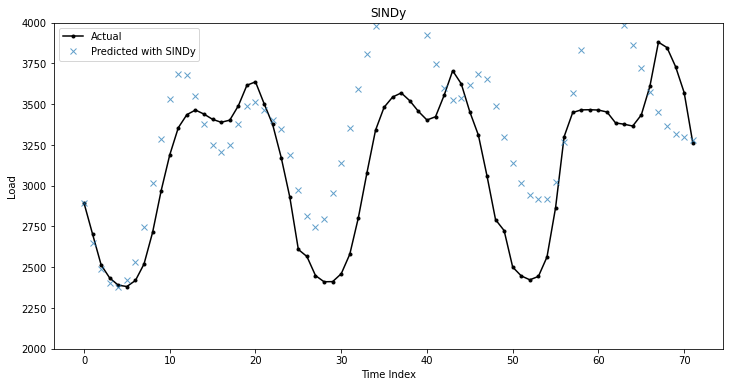

In [90]:
#Plotting predictions: 
mpl.rcParams['figure.figsize'] = [12.0, 6.0]
plt.figure();
plt.plot(eval_df['actual'], 'k.-');
plt.plot(eval_df['SINDy'], 'x', alpha=0.70);
#plt.plot(np.arange(0, 69),eval_df['prediction'].iloc[69:138], 'o', alpha=0.70);
#plt.plot(np.arange(0, 69),eval_df['prediction'].iloc[-69:], '+', alpha=0.70);
plt.legend(['Actual',
            ('Predicted with SINDy' )])
plt.ylabel('Load');
plt.xlabel('Time Index');
plt.ylim(2000, 4000)
plt.title('SINDy');


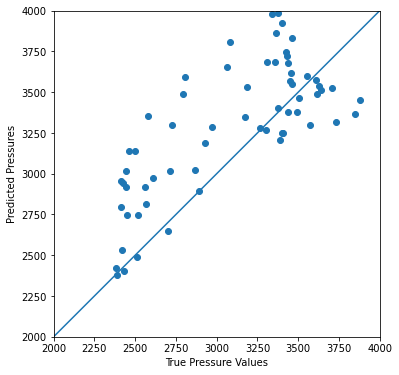

In [91]:
#Visualization of the accuracy:
a = plt.axes(aspect='equal')
plt.scatter(eval_df['actual'], eval_df['SINDy'])
plt.xlabel('True Pressure Values')
plt.ylabel('Predicted Pressures')
lims = [2000, 4000]
plt.xlim(lims), plt.ylim(lims)
plt.plot(lims, lims)

Text(0, 0.5, 'Count')

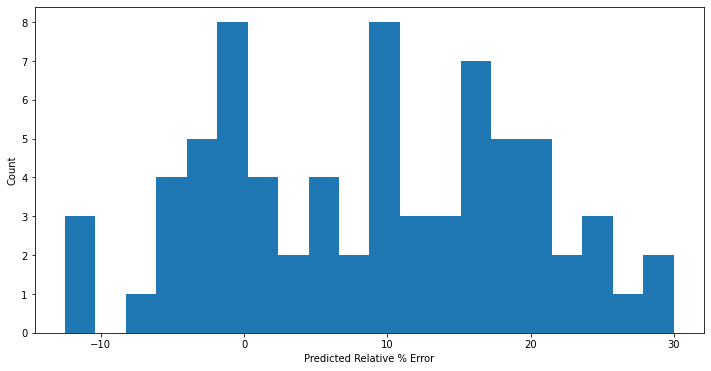

In [92]:
# Calculating the error variations:
#eval_df['actual'], eval_df['SINDy']
error_nn = (eval_df['SINDy'] - eval_df['actual'])/eval_df['actual']*100
plt.hist(error_nn, bins=20)
plt.xlabel('Predicted Relative % Error')
plt.ylabel('Count')

In [93]:
#Calculating the mean absolute percentage error:
abs_error_nn = abs(eval_df['SINDy'] - eval_df['actual'])/eval_df['actual']*100
np.average(error_nn)

8.76956055190597

# References

Below you will find recent SINDy applications and relevant publications.



+ Sparse learning of stochastic dynamical equations
https://aip.scitation.org/doi/10.1063/1.5018409

+ Discovering governing equations from data by sparse identification of nonlinear dynamical systems
https://www.pnas.org/content/113/15/3932

+ Sparse identification of a predator-prey system from simulation data of a convection model 
https://aip.scitation.org/doi/10.1063/1.4977057

+ Multidimensional Approximation of Nonlinear Dynamical Systems 
https://asmedigitalcollection.asme.org/computationalnonlinear/article-abstract/14/6/061006/726935/Multidimensional-Approximation-of-Nonlinear?redirectedFrom=fulltext

+ Reactive SINDy: Discovering governing reactions from concentration data 
https://aip.scitation.org/doi/10.1063/1.5066099

+ Sparse identification of nonlinear dynamics for model predictive control in the low-data limit
https://royalsocietypublishing.org/doi/10.1098/rspa.2018.0335


+ Sparse structural system identification method for nonlinear dynamic systems with hysteresis/inelastic behavior 
https://www.sciencedirect.com/science/article/abs/pii/S0888327018305727?via%3Dihub

+ Constrained sparse Galerkin regression
https://www.cambridge.org/core/journals/journal-of-fluid-mechanics/article/abs/constrained-sparse-galerkin-regression/0E18A4A55FF5AC1401D236C0E4D1CAAE

+ A compressed-sensing method for identifying the best low-dimensional descriptor in an immensity of offered candidates
 https://journals.aps.org/prmaterials/abstract/10.1103/PhysRevMaterials.2.083802

+ Using noisy or incomplete data to discover models of spatiotemporal dynamics
 https://journals.aps.org/pre/abstract/10.1103/PhysRevE.101.010203

+ Data-driven discovery of partial differential equations
 https://advances.sciencemag.org/content/3/4/e1602614

+ Learning partial differential equations via data discovery and sparse optimization
 https://royalsocietypublishing.org/doi/10.1098/rspa.2016.0446

+ Sparse model selection via integral terms
 https://journals.aps.org/pre/abstract/10.1103/PhysRevE.96.023302

+ Distilling Free-Form Natural Laws from Experimental Data
 https://science.sciencemag.org/content/324/5923/81

+ Sparse identification for nonlinear optical communication systems: SINO method 
 https://www.osapublishing.org/oe/fulltext.cfm?uri=oe-24-26-30433&id=356963

+ Exact Recovery of Chaotic Systems from Highly Corrupted Data
https://epubs.siam.org/doi/10.1137/16M1086637

+ A Unified Framework for Sparse Relaxed Regularized Regression: SR3
https://ieeexplore.ieee.org/document/8573778

+ Data-driven discovery of coordinates and governing equations
https://www.pnas.org/content/116/45/22445


